# Introduction

This project focused on predicting whether the Amazon user purchase certain food product in Amazon based on baseline popularity, logistics regression and collabrative filtering model. The project also utilized a linear support vector machine, logistics regression, decision tree and random forest model for sentiment analysis for user’s review text. 

Group member:
Shuai Meng (Penn ID:45048284)
Yuwei Song (Penn ID:86582583)

# Exploratory Data Analysis

# 1 Data Pre-processing

Dataset is obtained from:https://tianchi.aliyun.com/dataset/dataDetail?dataId=31823 This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews frome October 1999 up to October 2012. Reviews include product and user information, ratings, and a plaintext review and so on.

In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
import matplotlib.style as style
import seaborn as sns
from scipy.interpolate import make_interp_spline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

## 1.1 Read txt-data into DataFrame

In [2]:
import sys
from pandas import DataFrame   
import pandas as pd            

dict_data={}
 
with open('finefood.txt','r')as df:
    for line in df:
        if line.count('\n') == len(line):
            continue
        for kv in [line.strip().split(':')]:
            dict_data.setdefault(kv[0],[]).append(kv[1])
            
columnsname=list(dict_data.keys())

frame = DataFrame(dict_data,columns=columnsname)

frame.columns= ['productId','userId','profileName','helpfulness','score','time','summary','text']

In [3]:
frame.head()

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned ...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanu...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a f...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient ...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wi...


The text file of dataset was read into a dataframe("frame") as shown in the table above. The dataframe contains the follow columns:

1. productId: identity number of food product in Amazon;
2. userId: user/purchaser that has bought food product and has reviewed for it in Amazon;
3. profileName: user’s profile name;
4. score: purchaser's rating for the corresponding product;
5. time: purchase time;
6. summary: summary of review text;
7. text: review text;
8. helpfulness: the molecule is the helpful comment number for corresponding review text, and the denominator is the total comment number for corresponding review text.


## 1.2 Data Wrangling and Cleaning

The raw data showed above did not meeting the requirements of this project. Therefore, data cleaning and wrangling was applied to the data:

1. Drop the duplicates;
2. Clean data in “userId” column which contain invalid string like “#”;
3. Converter data type;
4. Change the format of date in “time” column, and store the new format of date in “Year”, “Month” and “Day” columns;
5. Calculate the length of review text and store it in “text_len” column;
6. Split “helpfulness” column into two columns “com_helpful” and “com_total”, which store helpful comment number and total comment number for corresponding review text respectively;
7. Calculate the helpfulness rate based on “com_helpful” and “com_total”, and store it in “com_help_rate” column.


In [4]:
# Drop data
frame.drop_duplicates(inplace = True) 
# frame.isnull().any() 

In [5]:
#Converter dtype
def dtype_converter_int(df, int_columns):
  """converts columns to type integer

  :param df: dataframe to convert
  :param int_columns: list of columns to convert
  :return: dataframe
  """
  for i in int_columns:
        df[i] = df[i].apply(lambda x: int(x))
  
  return df

def dtype_converter_float(df, float_columns):
  """converts columns to type float

  :param df: dataframe to convert
  :param float_columns: list of columns to convert
  :return: dataframe
  """
  for i in float_columns:
        df[i] = df[i].apply(lambda x: float(x))
  
  return df


frame_col_float = ["score"]
frame = dtype_converter_float(frame, frame_col_float) 

frame_col_int = ["time"]
frame = dtype_converter_int(frame, frame_col_int) 

In [6]:
# Calculate the length of review text and store it in “text_len” column
frame['text_len'] = frame["text"].apply(lambda x: len(x))

In [7]:
# Extracting the number of 'helpful'  and the total number of comment ('helpful' and 'not helpful') on the review, and the 'helpful rate'.
# These are represented by 'com_helpful', 'com_total', and 'com_help_rate'.

def rate_calculator(x):
    try:
        return float(x.split('/')[0]) / float(x.split('/')[1])
    except:
        return 0

frame['com_helpful'] = frame['helpfulness'].apply(lambda x: int(x.split('/')[0]))
frame['com_total'] = frame['helpfulness'].apply(lambda x: int(x.split('/')[1]))
frame['com_help_rate'] =   frame['helpfulness']. apply(lambda x: rate_calculator(x))
frame.drop(['helpfulness'], axis = 1, inplace = True)
frame.drop(frame[frame['com_helpful'] > frame['com_total']].index, axis = 0,inplace = True) # drop two invalid lines，which helpfulness number is more than total number

In [8]:
# Change the format of year, month and day

import time, datetime

frame["time"] = frame["time"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d")) # don't consider %H:%M:%S, because all is 8: 00，

# Extracting year, month and day
frame['Year'] = frame['time'].apply(lambda x: int(x.split('-')[0]))
frame['Month'] = frame['time'].apply(lambda x: int(x.split('-')[1]))
frame['Day'] = frame['time'].apply(lambda x: (x.split('-')[2]))

In [9]:
#Clean data in “userId” column which contain invalid string like “#”
y = frame[frame['userId'].str.contains('#')]# which is not what we want
lst1 = list(y.userId) # represent elements containing # as lst1 in a list form
lst2 = list(frame.userId) # represent elements from dataframe as lst2 in a list form
ret = list(set(lst2)^set(lst1)) # The element containing # in this column is removed by using the list differential set method
frame = frame[frame.userId.isin(ret)] 
#https://www.jb51.net/article/159052.htm

In [10]:
frame.dtypes

productId         object
userId            object
profileName       object
score            float64
time              object
summary           object
text              object
text_len           int64
com_helpful        int64
com_total          int64
com_help_rate    float64
Year               int64
Month              int64
Day               object
dtype: object

In [11]:
frame.head(3)

,productId,userId,profileName,score,time,summary,text,text_len,com_helpful,com_total,com_help_rate,Year,Month,Day
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5.0,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned ...,264,1,1,1.0,2011,4,27
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1.0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanu...,191,0,0,0.0,2012,9,07
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4.0,2008-08-18,"""Delight"" says it all",This is a confection that has been around a f...,510,1,1,1.0,2008,8,18



After data cleaning and wrangling above, now, this dataframe was good fit for this project.

# 2 Data Exploration and Visualization

## 2.1 Basic Feature for data

In [12]:
# number of products
total_product = len(frame.groupby(by='productId',as_index = False).size())
#number of users
total_user = len(frame.groupby(by='userId',as_index = False).size())

print('Total sales volume:', len(frame))
print('Total Products:', total_product)
print('Total User:', total_user)

Total sales volume: 567453
Total Products: 74258
Total User: 255561


In [13]:
display(frame[['score', 'text_len']].describe())

,score,text_len
count,567453.000000,567453.000000
mean,4.184708,388.696158
std,1.309228,352.547278
min,1.000000,1.000000
25%,4.000000,171.000000
50%,5.000000,283.000000
75%,5.000000,483.000000
max,5.000000,11899.000000


During the data period (October 1999 to October 2012), the total sales volume of all products could reach 567453, but there were 255561 buyers and only 74258 products, which means that some users had more than one purchase records and some products were bought by different users.

As shown in the table above, products usually got relatively high score as more than 25% purchasers scored more than 4 points for their products; purchasers usually reviewed around 400 words for a product they bought.

## 2.2 Interannual Variability and Statistical Analysis for Features

### 2.2.1 Exploration for Purchases and Score

In [14]:
font3 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 20}

Text(0.5, 1.0, 'Interannual trend of all-product average score')

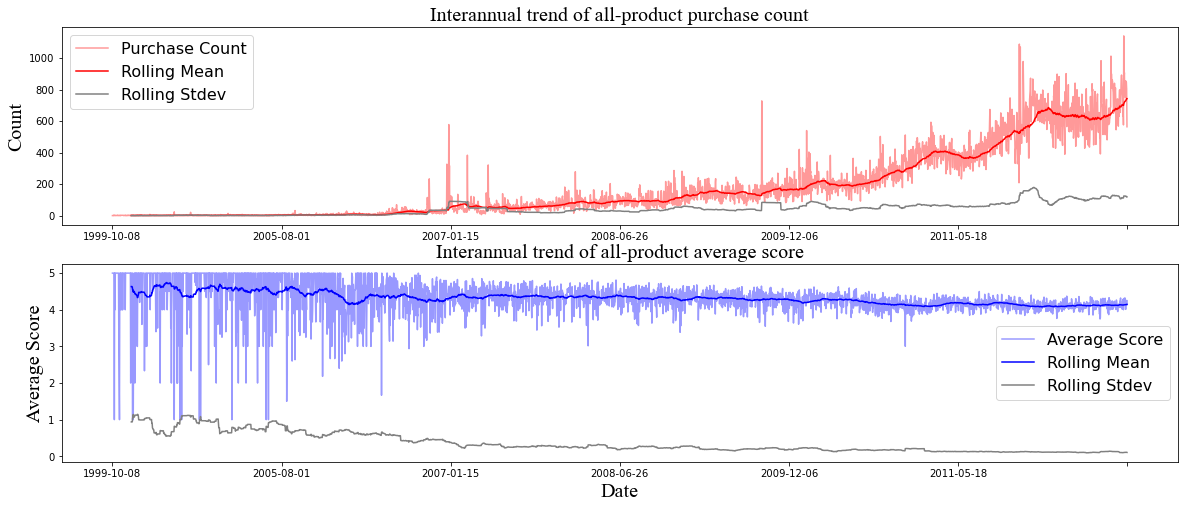

In [15]:
# 1. Interannual trend of all-product purchase count
group_frame1 = frame.groupby(['time'])[['userId']].count().reset_index()
group_frame1.rename(columns = {'time': 'Date', 'userId':'Count'}, inplace = True)
# 2. Interannual trend of all-product average score
group_frame2 = frame.groupby(['time'])[['score']].mean().reset_index()
group_frame2.rename(columns = {'time': 'Date', 'score':'Average Score'}, inplace = True)

ts = pd.Series(group_frame1['Count'].values, index=group_frame1['Date'])
rolling_mean = pd.Series.rolling(ts,center=False,  window=60).mean()
rolling_std = pd.Series.rolling(ts,center=False, window=60).std()

ts2 = pd.Series(group_frame2['Average Score'].values, index=group_frame2['Date'])
rolling_mean2 = pd.Series.rolling(ts2,center=False,  window=60).mean()
rolling_std2 = pd.Series.rolling(ts2,center=False, window=60).std()



fig1 = plt.figure(2, figsize=(20,8))
ax1 = plt.subplot(211)
plt.plot(ts,color='red', alpha=0.4, label='Purchase Count')
plt.plot(rolling_mean,color='red', label='Rolling Mean')
plt.plot(rolling_std,color='gray',label='Rolling Stdev')
new_ticks = np.linspace(0,len(ts), 7)
plt.xticks(new_ticks)
plt.legend(fontsize = 16)
plt.ylabel('Count', font3)
plt.title('Interannual trend of all-product purchase count',font3)


ax2 = plt.subplot(212)
plt.plot(ts2,color='b', alpha=0.4, label='Average Score')
plt.plot(rolling_mean2,color='b', label='Rolling Mean')
plt.plot(rolling_std2,color='gray',label='Rolling Stdev')
new_ticks = np.linspace(0,len(ts), 7)
plt.xticks(new_ticks)
plt.legend(fontsize = 16)
plt.xlabel('Date', font3)
plt.ylabel('Average Score', font3)
plt.title('Interannual trend of all-product average score',font3)


The figure shown on the top illustrates the interannual variation of all-product purchase count over October 1999 up to October 2012. It shows a dramatically increase for the demand of food in Amazon. So, it is worthwhile to explore Recommendation System and Reviews Sentiment Analysis for Amazon. The figure on the bottom shows a stable trend for average score of every purchase over time. There was a slight decrease in the score, which indicates that the purchaser's standards for food product have improved generally. These phenomenon lays the foundation for the later research of sentiment analysis.
 


Text(0.5, 1.0, 'Monthly variation of all-product sales count and average score')

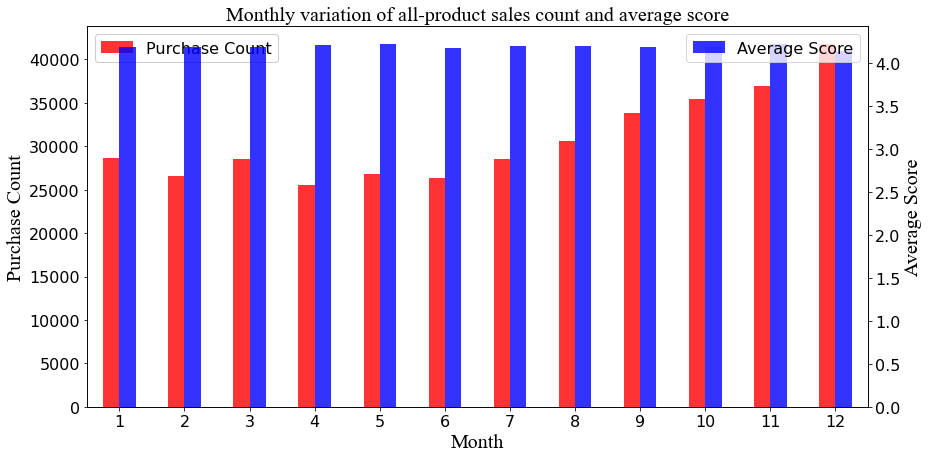

In [16]:

# 3. Monthly variation of all-product sales count
group_frame3 = frame.groupby(['Month'])[['userId']].count().reset_index()
group_frame3.rename(columns = {'userId':'Purchase Count'}, inplace = True)
group_frame32 = frame[(frame['Year']!=2012) & (frame['Year']!=1999)].groupby(['Month'])[['userId']].count().reset_index() # don't consider 1999 & 2012
group_frame32.rename(columns = {'userId':'Purchase Count'}, inplace = True)
# 4. Monthly variation of average score
group_frame4 = frame.groupby(['Month'])[['score']].mean().reset_index()
group_frame4.rename(columns = {'score':'Average Score'}, inplace = True)
# 3&4.
group_frame324 = pd.concat([group_frame32, group_frame4[['Average Score']]], axis=1, copy = False)



fg = group_frame324.plot(kind='bar', x = 'Month', y = ['Purchase Count', 'Average Score'], secondary_y=['Average Score'], color = ['r','b'], alpha=0.8, fontsize =16, figsize = (14,7))
fg.set_ylabel('Purchase Count', font3)
plt.ylabel('Average Score', font3)

fg.set_xticklabels(group_frame4['Month'], rotation=0)
fg.legend(loc='upper left', fontsize =16, framealpha = 1)
plt.legend(loc='upper right', fontsize = 16)

fg.set_xlabel('Month', font3)
plt.title('Monthly variation of all-product sales count and average score',font3)

This project also explored the monthly variation of all-product purchase count and average score of every purchase over time. The average score has nothing to do with month as the figure shown. As for the monthly purchase count, this project only considered the data from 2000 to 2011 since the data from January to December was incomplete in 1999 and 2012. The monthly purchase count shows a obviously trend: the volume of purchase is less in spring and summer, and more in autumn and winter, which might be related to the tradition of Christmas shopping spree and also New Year's Day.


Text(0.5, 1.0, 'Interannual(2006-2012) and seasonal variation of all-product sales count')

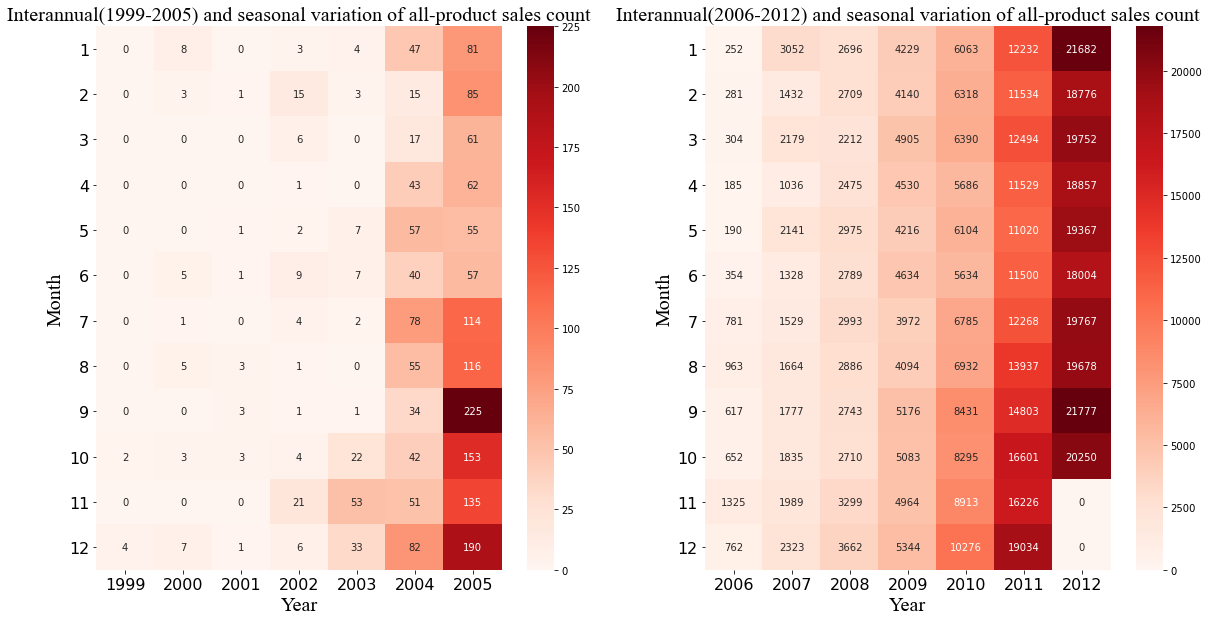

In [17]:
# 5. Interannual and seasonal variation of all-product sales count
group_frame5 = frame.groupby(['Year','Month'])[['userId']].count()
group_frame5.rename(columns = {'userId':'Count'}, inplace = True)

df5 = pd.DataFrame(columns = range(1999,2013), index=range(1,13))  
for i in range(1,13):
    for j in range(1999,2013):
        try:
            df5.at[(i,j)] = group_frame5.loc[(j,i),'Count']
        except:
            df5.at[(i,j)] = 0

frame_col_int = range(1999,2013)
df5 = dtype_converter_int(df5, frame_col_int) 


f, (ax1,ax2) = plt.subplots(figsize = (20,10),ncols=2)
sns.heatmap(df5.loc[1:12,1999:2005], ax = ax1, annot = True, fmt="d", cmap="Reds")
ax1.set_yticklabels(range(1,13), rotation = 0, fontsize =16)
ax1.set_xticklabels(range(1999,2006), fontsize =16)
ax1.set_ylabel('Month', font3)
ax1.set_xlabel('Year', font3)
ax1.set_title('Interannual(1999-2005) and seasonal variation of all-product sales count', font3)
sns.heatmap(df5.loc[1:12,2006:2012], ax = ax2, annot = True, fmt="d", cmap="Reds")
plt.yticks(rotation=0, fontsize =16) 
plt.xticks(fontsize =16) 
plt.ylabel('Month', font3)
plt.xlabel('Year', font3)
plt.title('Interannual(2006-2012) and seasonal variation of all-product sales count', font3)


The heat map above shows the variation of the volume of purchases via time more clearly: purchases increased rapidly with years, and it was related to the season.


###  2.2.2 Exploration for Review Text and Comment Number

Text(0.5, 1.0, 'Interannual trend of total comment number for reviews')

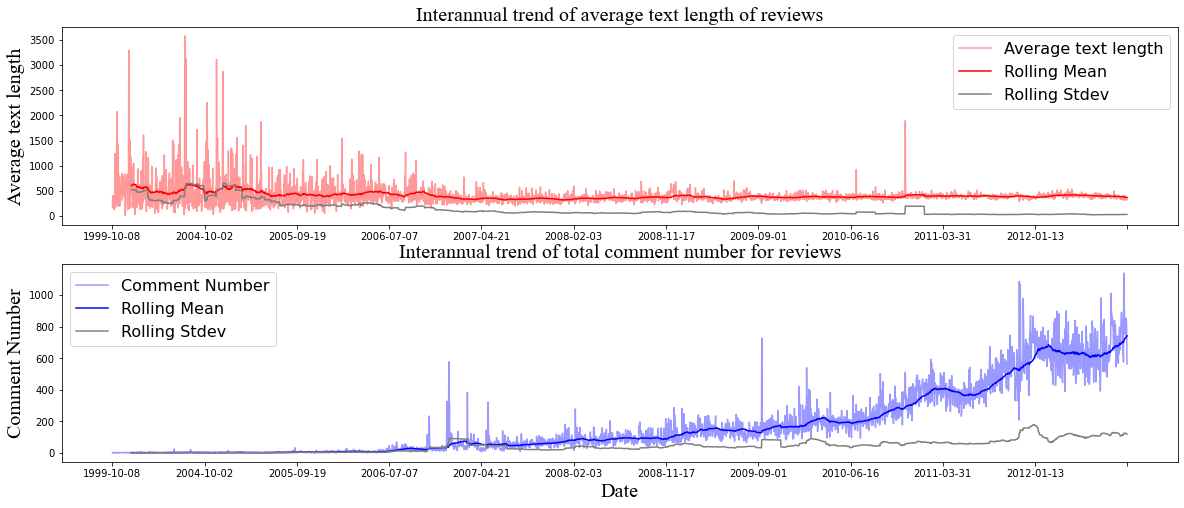

In [18]:
# 6. Interannual trend of average text length of reviews
group_frame6 = frame.groupby(['time'])[['text_len']].mean().reset_index()
group_frame6.rename(columns = {'time': 'Date','text_len': 'Average text length'}, inplace = True)
# 7. Interannual trend of total comment number for reviews
group_frame7 = frame.groupby(['time'])[['com_total']].count().reset_index()
group_frame7.rename(columns = {'time': 'Date','com_total': 'Comment Number'}, inplace = True)

ts = pd.Series(group_frame6['Average text length'].values, index=group_frame6['Date'])
rolling_mean = pd.Series.rolling(ts,center=False,  window=60).mean()
rolling_std = pd.Series.rolling(ts,center=False, window=60).std()

ts2 = pd.Series(group_frame7['Comment Number'].values, index=group_frame7['Date'])
rolling_mean2 = pd.Series.rolling(ts2,center=False,  window=60).mean()
rolling_std2 = pd.Series.rolling(ts2,center=False, window=60).std()


fig1 = plt.figure(2, figsize=(20,8))
ax1 = plt.subplot(211)
plt.plot(ts,color='red', alpha=0.4, label='Average text length')
plt.plot(rolling_mean,color='red', label='Rolling Mean')
plt.plot(rolling_std,color='gray',label='Rolling Stdev')
new_ticks = np.linspace(0,len(ts), 12)
plt.xticks(new_ticks)
plt.legend(fontsize = 16)
plt.ylabel('Average text length', font3)
plt.title('Interannual trend of average text length of reviews',font3)

ax2 = plt.subplot(212)
plt.plot(ts2,color='b', alpha=0.4, label='Comment Number')
plt.plot(rolling_mean2,color='b', label='Rolling Mean')
plt.plot(rolling_std2,color='gray',label='Rolling Stdev')
new_ticks = np.linspace(0,len(ts), 12)
plt.xticks(new_ticks)
plt.legend(fontsize = 16)
plt.xlabel('Date', font3)
plt.ylabel('Comment Number', font3)
plt.title('Interannual trend of total comment number for reviews',font3)

The figure on the top illustrates the interannual trend of average text length of reviews, which shows clearly that the overall situation of the length of reviews remained unchanged over the year. As for the bottom figure, the total comment numbers for review text keeps rising, which indicates that more and more people are paying attention to the review of products and thus the review would affect the purchase number of products.


Text(0.5, 1.0, 'Frequency of Helpfulness Rate for Review')

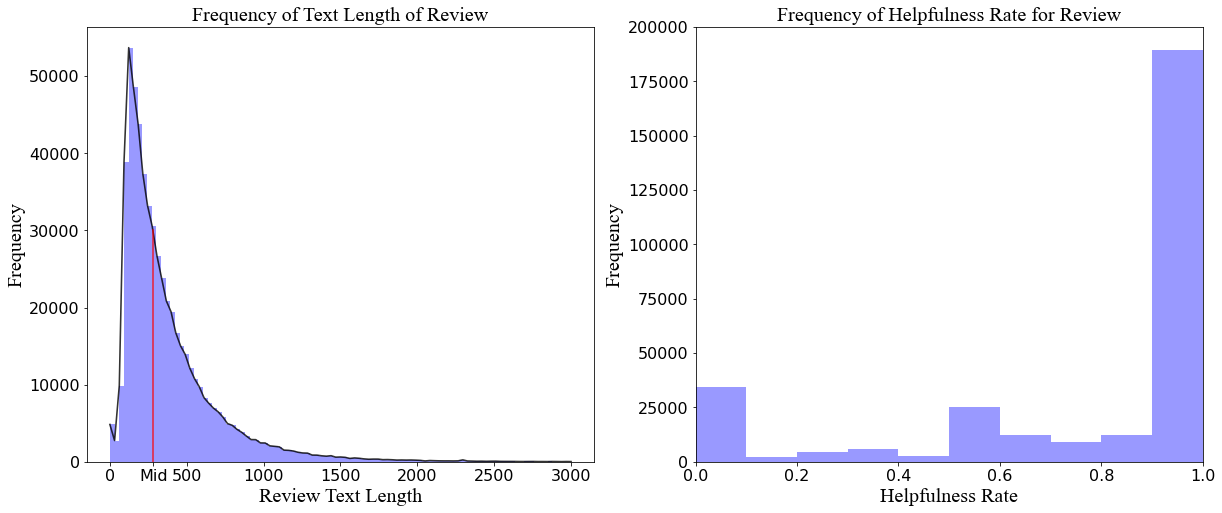

In [19]:
text_len_mid = frame[['score', 'text_len', 'com_help_rate']].describe()['text_len']['50%'] 


fig1=plt.figure(2, figsize=(20,8))


# 7. Frequency of Text Length of Review
ax1 = plt.subplot(121)
bins = np.linspace(0, 3000, 100)
x = np.linspace(0, 3000, 99)
y, _, _  = plt.hist(frame['text_len'], bins, color = "b", alpha=0.4)
plt.plot(x, y, linewidth=1.6,  color = "k", alpha=0.8)
plt.plot([text_len_mid,text_len_mid], [0,30000], linewidth=1.5, color = "r", alpha=0.8)
ax1.set_xticks(list([0,text_len_mid,500,1000,1500,2000,2500,3000]))
ax1.set_xticklabels(list([0,'Mid',500,1000,1500,2000,2500,3000]))
plt.yticks(rotation=0, fontsize =16) 
plt.xticks(fontsize =16) 
plt.ylabel('Frequency', font3)
plt.xlabel('Review Text Length', font3)
plt.title('Frequency of Text Length of Review', font3)

# 8. Frequency of Helpfulness Rate for Review
# not consider 269634 data, which 'com_total' == 0.
plt.subplot(122)
bins = np.linspace(0,1,11)
plt.hist(frame[frame['com_total']!=0]['com_help_rate'], bins, color = "b", alpha=0.4)
plt.axis([0, 1.0, 0, 200000])
plt.yticks(rotation=0, fontsize =16) 
plt.xticks(fontsize =16) 
plt.ylabel('Frequency', font3)
plt.xlabel('Helpfulness Rate', font3)
plt.title('Frequency of Helpfulness Rate for Review', font3)


The figure on right shows the statistics on the length of review text. We found that most of the length of reviews was not greater relatively. Usually, if the review was long, the purchaser might make complaints about them, which implicit that most purchasers were satisfied with their purchases.

As for the helpfulness rate for the review shown on right, most of the purchasers thought review was helpful, which means that the review would influence other purchasers significantly. This further suggests the importance of studying the Reviews Sentiment Analysis for Amazon.

# Modelling

# 3. Prediction of Customer Purchase Behavior

The recommendation system is designed to recommend relevant products for users according to their previous purchasing behaviors, which are basically to model people's preferences, opinions and behaviors, so as to personalize the user's experience and provide more profits for merchants. When purchasing merchandise, enterprises can adopt more intelligent strategies to allocate and adjust the quantity of each item, and finally achieve profit growth.

In this section, we use three models to predict whether a customer will purchase an item or not: Baseline Popularity Model, Logistic Regression Model and User-based Collaborative Filtering Model. The principle of this part is mainly: first on the basis of user's history purchase behavior, we train these three models. Then for any user, when he encounter a specific goods, our model will determine whether he will buy this item or not. If the prediction is to buy, we will have the confidence to infer that user is likely to buy the product and recommend this product to him accordingly.

## 3.1 Data Preprocessing

In the data preprocessing phase, what we need to do is to match each user ID with the product ID for subsequent machine learning model training and, more importantly, to create train data set and test data set. For test data, one difficulty we ran into was that the original data set represents all the users' purchase behaviors, and we don't actually have a data set of non-purchase behaviors in terms of a specific user. Therefore, if we use the original data set directly, all of results are 1 (means "buy"), which will bring bias to our model, and that's not what we want. 

In order to generate the test data, we randomly select IDs from both customer and product lists and pair them. At the same time, we have to ensure that they do not already show up together in the training set. We assume that any user-item pair, as long as they are not present in our training set, is a piece of non-purchase information.

In [11]:
# generate user-item pairs
all_user = list()
all_item = list()
#for column in frame:
all_user = frame['userId'].tolist() #convert the column dataframe to a list
all_item = frame['productId'].tolist()
    
unique_user = list(set(all_user)) #in order to make sure that duplicated userId-productId will not be recorded.
unique_item = list(set(all_item))

all_pairs = ['{}-{}'.format(all_user[i].strip(), all_item[i].strip()) for i in range(len(all_item))] #form the user-product pairs
random.seed(1)
random.shuffle(all_pairs)#shuffle the order of pairs (in the same way-random seed is fixed)


In [12]:
#overview of the data and length
print("unique pairs: ")
print(len(set(all_pairs)))
all_pairs[0:10]

unique pairs: 
560090


['A1QXSCQZQC8CAG-B000GQTP1S',
 'A2PTI0A4TZ9I73-B0040PWIHE',
 'AJFMYOLRWDJ46-B001E5E0AG',
 'A1BYJBZZ56ZB87-B001TORSC4',
 'AFE275TD1871Q-B001M2BM4I',
 'AW5JSQCHC2ZJO-B005SPQENY',
 'A1JMR1N9NBYJ1X-B0090X8IPM',
 'A39IW64JWDI7B3-B001M19IJK',
 'A3AOD28SLOIQ4C-B000LQORDE',
 'A1W4ZRZL9VTEZ0-B0002YB40O']

Since the data is quite large, it will be time-consuming to work with all 560092 data samples. Now we split the training data as follows: Reviews 1-450,000 for training Reviews 450,001 - 500,000 + 50,000 non-purchases for validation. To avoid the bias in the training dataset, we will scramble the whole training data set.

In [13]:
# generate non-purchased samples
length = 0 #first initialize the length of non-purchase pairs to be null.
while length < 50000: # we have to build a non-purchase database which contains more than 50000 samples.
    random.seed(2)
    user = list(np.random.choice(unique_user, size = 200000, replace = True)) #we randomly select some of the user/customers
    random.seed(2)
    item = list(np.random.choice(unique_item, size = 200000, replace = True)) #"size" means the size of the user/customer we randomly choose  
    #replace = True means we accept taking the same user/customer
    
    select = set(['{}-{}'.format(user[i].strip(), item[i].strip()) for i in range(len(item))])
    select = select.difference(set(all_pairs)) #select.difference means we don't want any set of pairs to appear in all_pairs 
                                               #because it means that this specific set of user - product pairs indicates a purchase behavior
    length = len(select)
random.seed(2)
non_purchase = list(np.random.choice(list(select), size = 50000, replace = False)) #we choose 50000 pairs from "select" list

In [16]:
#overview of non-purchase data
non_purchase[0:10]

['A5H6WYKWE6T4D-B000F0FX52',
 'A1ZFB2NF055I5X-B000XK71JK',
 'AG0G9QNVMNVMK-B003ZNXCFO',
 'A2SWVRWMDLGOHM-B008CQJBI6',
 'A348L9GV9VPIS5-B001FA1DO6',
 'A14OBF9F7VEOI1-B005VI0JCA',
 'AGAUM9OKEIZC4-B004DNEF60',
 'A13435N0XLM7VQ-B000FPVHTI',
 'A1SRA8L1LEC1E0-B001EQ5SFG',
 'A3O2KQH4ZL23UD-B000LRIKZY']

The test set has been constructed such that exactly 50% of the pairs correspond to purchased items and the other 50% do not.

In [48]:
# generate training and validation set
train_set = all_pairs[0: 450000]
test_set = all_pairs[450001:500000] + non_purchase

## 3.2 Baseline popularity model:

This model is used to judge whether a product is popular or not by ranking all items based on their quantity of sales. The basic foundation of our assumption is that if a item is more popular, it is more likely to be bought by customers. The same rule also applies to customers: a regular shopper (known as a popular shopper) means he will have a greater chance of buying any item he comes across. 

Therefore, we have three types of baseline popularity model: 
1. ispopular(item) = true,  predict = purchase
2. ispopular(customer) = true, predict = purchase
3. ispopular(item) = true and ispopular(customer) = true, predict = purchase

The next issue to solve is the defination of "popular". In this project, we describe popularity as follow:
<center> $\textbf{number of purchase (purchased) items > total purchase (purchased) number} \times \textbf{threshold}$</center>  
Any products that account for threshold percentage of total quantity of purchases will be regarded as a popular good. We rank each customer by the number of items they purchased, and defined popular customer as the number of items purchased is greater than the total number of items multiplied by the threshold. With regards to the threshold, we would discuss later about how much of this threshold to set will be the best for research purposes. 

In [49]:
def pred_popu_model(train, test, threshold, parameter):
    '''
    predict if item in each pair belongs to most popular items
    parameter = 0 indicates product and parameter = 1 indicates user
    output: a list of most popular items 
    '''
    total = 0
    if parameter == 0:
        item_count = defaultdict(int) # set the initialization dictionary and takes any int as input
        for data in train:
            user, item = data.split('-')
            item_count[item] += 1 # count the number of occurrences of each item
            total += 1
        
        popularity = [(item_count[i], i) for i in item_count]
        popularity.sort()
        popularity.reverse() #form a list which is like: [(the occurence, the most popular item),....] sort by descending order
    
    elif parameter == 1:
        user_count = defaultdict(int) # set the initialization dictionary and takes any int as input
        for data in train:
            user, item = data.split('-')
            user_count[user] += 1 # count the number of occurrences of each item
            total += 1
        
        popularity = [(user_count[i], i) for i in user_count]
        popularity.sort()
        popularity.reverse() #form a list which is like: [(the occurence, the most popular item),....] sort by descending order
        
        
    result = set() #initialize set is aimed to avoid duplications
    count = 0
    
    for a, b in popularity: # form a popular item list (satisfy that the count is greater than total number of items*threshold)
        count += a 
        result.add(b)
        if count > total*threshold: 
            break


    pred = []
    if parameter == 0:
        for data in test:
            user, item = data.split('-')
            if item in result: # if the item appears in the popular item list as we defined before, then we label it "1"
                pred.append(1)
            else:
                pred.append(0) # if not, we label it "0" 
                
    elif parameter == 1:
        for data in test:
            user, item = data.split('-')
            if user in result:
                pred.append(1)
            else:
                pred.append(0)  
    return pred


def accuracy(pred): # this accuracy function was designed specially for this model
    length = len(pred) #because we know that the first half of the validation set is the items that were purchased and the second half were not. 
    acc = 0
    for i in range(0, int(length/2)):# When we predict that this product is popular, we assume that a customer will buy the product. 
        if pred[i] == 1: #Therefore, if he predicts that this product is popular in the first half of the data set, then our prediction will be successful.
            acc = acc + 1
    for i in range(int(length/2), length):#and vice versa.
        if pred[i] == 0:
            acc = acc + 1
    acc = acc/length
    return acc


For an experiment, we first calculate the accuracy of the first type of baseline model at the initial threshold = 0.5

In [50]:
# for an experiment, we first return the accuracy of our model at the threshold = 0.5
pred = []
pred = pred_popu_model(train_set, test_set, 0.5, 0)
print('the accuracy of the baseline (threshold = 0.5) on the test set:', accuracy(pred))

the accuracy of the baseline (threshold = 0.5) on the test set: 0.7291472914729147


The next step is to find a optimal threshold in order to make our model more accurate based on the data. In order to do this, we draw scatter plot displaying the accuracy of different threshold and investigate the best parameter. (We draw all the three types of plots together)

In [51]:
accuracy1 = [] # a list to store all accuracy 
threshold = np.arange(0.1, 1, 0.01) # we select all values between 0.1 to 1 with an interval of 0.01 as our threshold 
for t in threshold:
    test = pred_popu_model(train_set, test_set, t, 0)
    accuracy1.append(accuracy(test))

best_threshold = threshold[np.argmax(accuracy1)] #return the best threshold 
best_accuracy = np.max(accuracy1)# return the best accuracy
print('best threshold:', best_threshold)
print('best accuracy:', best_accuracy)

best threshold: 0.7399999999999997
best accuracy: 0.7827478274782748


The similar rule from above, we would apply baseline popularity model to find out the popular list of customer and to calculate the accuracy of another two types of models.

In [52]:
pred = pred_popu_model(train_set, test_set, 0.5, 1)
print("the accuracy of the baseline (threshold = 0.5) on the validation set:", accuracy(pred))

accuracy2 = [] # a list to store all accuracy 
threshold = np.arange(0.1, 1, 0.01) # we select all values between 0.1 to 1 with an interval of 0.01 as our threshold 
for t in threshold:
    test = pred_popu_model(train_set, test_set, t, 1)
    accuracy2.append(accuracy(test))

best_threshold = threshold[np.argmax(accuracy2)]
best_accuracy = np.max(accuracy2)

print('best threshold is ', best_threshold)
print('best accuracy is ', best_accuracy)

the accuracy of the baseline (threshold = 0.5) on the validation set: 0.6483564835648357
best threshold is  0.5399999999999998
best accuracy is  0.6533465334653347


In [53]:
accuracy3 = [] # a list to store all accuracy 
for t in threshold:
    test1 = pred_popu_model(train_set, test_set, t, 0)
    test2 = pred_popu_model(train_set, test_set, t, 1)
    test3 = list()

    for i in range(len(test1)):
        if test1[i] == 1 and test2[i] == 1:# the third model indicates 1 (true), if and only if the another two types of models indicate true at the same time.
            test3.append(1)
        else:
            test3.append(0)
    
    
    accuracy3.append(accuracy(test3))
    del test1,test2

best_threshold = threshold[np.argmax(accuracy3)]
best_accuracy = np.max(accuracy3)

print('best threshold:', best_threshold)
print('best accuracy:', best_accuracy)

best threshold: 0.7399999999999997
best accuracy: 0.6994869948699487


Result: the accuracy of the baseline item popularity model on the test set is 0.729 (threshold = 0.5), the accuracy of the baseline user popularity model on the test set is 0.648 (threshold = 0.5). The best accuracy of baseline item popularity model is 0.782 with threshold = 0.74. The best accuracy of baseline user popularity model is 0.653 with threshold = 0.54. The best accuracy of baseline user popularity model is 0.699 with threshold = 0.74.

The code below is to visualize the accuracy variations with different threshold of three types of baseline models. We can choose the different threshold based on the diagram. In general, the item popularity model performs better than the user popularity model. The accuracy curve of almost all types of models show the same trend: increases first and then decreases. This is quite easy to understand: for example a fine food, if the threshold is trival, the probability of any item becoming popular increases, so the machine is likely to predict more user-item pairs as 1; By contrast, if the threshold is quite big, it becomes more difficult for goods to become popular goods, the machine tends to predict less data as 1. Both cases will lead to the decrease of model accuracy.

Text(0.5, 1.0, 'Accuracy Variations with Different Threshold')

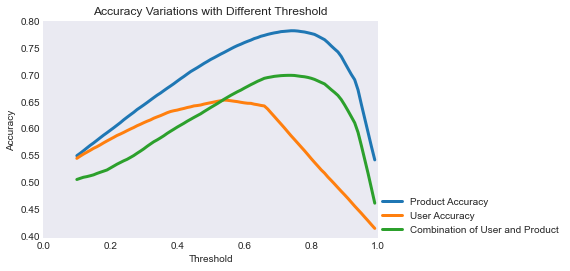

In [54]:
plt.style.use('seaborn-dark')
plt.plot(threshold, accuracy1, label='Product Accuracy', linewidth=3)
plt.plot(threshold, accuracy2, label='User Accuracy', linewidth=3)
plt.plot(threshold, accuracy3, label='Combination of User and Product', linewidth=3)
plt.legend(bbox_to_anchor=(1, 0),loc=3, borderaxespad=0)
plt.xlim((0, 1))

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Variations with Different Threshold')

## 3.3 Logistic Regression Model:

This section is another model of customer behavior prediction, which is mainly based on logistic regression algorithm. In machine learning, the logistic regression model, a "special linear regression" is used to model the probability of a certain binary class or event. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one. Different from the step function in linear regression, logistic regression utilizes sigmoid function to do prediction. In our research, we would rely on scikit-learn library to do analysis.

Before we work on logistic regression algorithm, our first step is to construct the response in training set. For a machine learning model, the training data set needs to be different from the previous training set. The reason is that the training set of the previous model can be all 1, because we don't really care about if the training data set consists of all 1 or not all 1, we intend to know which item is popular. However, for logistics Regression, if all of our training sets are 1, we would introduce a certain bias to the model unintentionally, which would result in a decrease in accuracy. According to the results in the above section, we select the first type of baseline popularity as the foundation for generating new training data: if the commodity is popular, we set the label to 1; otherwise, we change the original label to 0.

Besides, we need to convert the orginal data set into one-zero matrix to represent the purchase information, each row in the matrix represents for each user-item pair in order to do machine learning training. Because the initial feature is not numerical.
    

In [55]:
def user_logistic(train, test, threshold):
    '''
    output: accuracy of the model, prediction result(a list of 1 or 0)
    '''
    
    # generate new y_train based on the item popular baseline model. (parameter is set to zero)
    y_train = pred_popu_model(train, train, threshold, 0)
    
    # generate new x_train
    v = DictVectorizer() #The processing object of DictVectorizer is symbolic (non-digital) but has a certain structure of characteristic data, 
                         #which turns symbols into the number 0/1 for representation.
    temp = [{"user": data.split('-')[0], "item": data.split('-')[1]} for data in train] #construct a dict which includes user and item (key-value)
    X_train = v.fit_transform(temp) #transform it into a  one-zero matrix to represent the purchase information, each row in the matrix represents for each user-item pair.
    
    # fit_logistic
    clf = LogisticRegression()
    clf.fit(X_train, y_train) 
    
    # generate new x_val
    temp = [{"user": e.split('-')[0], "item": e.split('-')[1]} for e in test]
    X_val = v.transform(temp)
    
    pred = clf.predict(X_val)
    
    return accuracy(pred), pred

print('The accuracy of logistic regression(threshold = 0.5):', user_logistic(train_set, test_set, 0.5)[0])


/Users/mengshuai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of logistic regression(threshold = 0.5): 0.7291472914729147


In [56]:
# select the best threshold in this cell and do plotting.
acc = []
threshold = np.arange(0.1, 1, 0.05) #if the interval sets to be 0.01, the running will be really slow
for t in threshold:
    acc.append(user_logistic(train_set, test_set, t)[0])

best_threshold = threshold[np.argmax(acc)]
best_accuracy = np.max(acc)
print('best threshold: ', best_threshold)
print('best accuracy: ', best_accuracy)

/Users/mengshuai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mengshuai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

best threshold:  0.7500000000000002
best accuracy:  0.7815578155781557


Text(0.5, 1.0, 'Accuracy Variations with Different Threshold for Logistics Regression')

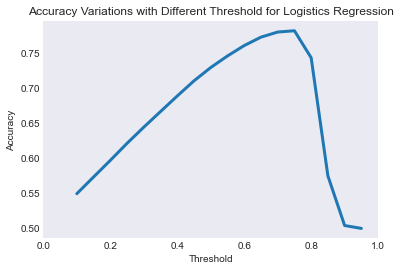

In [57]:
plt.style.use('seaborn-dark')
plt.plot(threshold, acc, linewidth=3)
plt.xlim((0, 1))

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Variations with Different Threshold for Logistics Regression')

For logistic regression mode, the best threshold we select is 0.75 with the maximum accuracy: 0.782. The accuracy variation graph is much resemble with the previous model.

## 3.4  User-based Collaborative Filtering Model:

Collaborative filtering is to build a matrix which shows the relationship between users or items, then we can infer the preference of an user by checking the matrix and matching the user’s information.

We measured the similarity by Jaccard Similarity, the Jaccard similarity between A and B is calculated by the following formula:

<center> $J(A,B)=\frac{|A\cap B|}{|A\cup B|}$</center>  
To simplify the problem, we considered if two users purchased at least one common item, then recorded the similarity between two users as 1, otherwise is 0.

To predict a pair of user and item, say U1-I1, we checked any other users who purchased I1, say Ui, if the Jaccard similarity between U1 and Ui is positive (which means they are likely to by common items again), then we predicted U1-I1 as '1', otherwise is '0'. 

In [58]:
test_data = all_pairs[90001:90501] + non_purchase[0:100]

In [41]:
train_set = all_pairs[0:90000]
# Build utility matrix
train_user = []
train_item = []
for e in train_set:
    user, item = e.split('-')
    train_user.append(user)
    train_item.append(item)
    
unique_user = list(set(train_user))
unique_item = list(set(train_item))
    
rating = [1 for i in range(len(train_user))]

a = {'user': pd.Series(train_user), 
    'item': pd.Series(train_item), 
    'rating': pd.Series(rating)}
df = pd.DataFrame(a)  
table = df.pivot_table(index = 'user', columns = 'item', values = 'rating')

In [59]:
def similarity_model(train, test):
    '''
    A function to train and predict collaborative filtering model
    '''
    
    pred = []
    # predict each pair
    for e in test:
        user, item = e.split('-')
        if user in train_user and item in train_item:
            col = table[item]
            temp_users = col[col == 1].index.tolist()
            
            # measure the similarity of other users who also purchased the item in the pair
            # and the user in the pair
            has_common = False
            for u in temp_users:
                if u != user:
                    row1 = table.loc[user]
                    row2 = table.loc[u]
                    common = set(row1[row1 == 1].index.tolist()) & set(row2[row2 == 1].index.tolist())
                    if len(common) != 0:
                        has_common = True
                        break
                        
            # if similarity is positive, predict user-item as 1
            # otherwise as 0
            if has_common:
                pred.append(1)
            else:
                pred.append(0)
        else:
            pred.append(0)
    return pred, accuracy(pred)
    
print("The accuracy:", similarity_model(train_set, test_data)[1])

The accuracy: 0.545


The final accuracy of User-based Collaborative Filtering Model is 0.545 with newly generated train and test data.
There are some problems here which partially influence the accuracy of the result:
Due to the high version of Pandas, one of the operations in our code: 

<center>table = df.pivot_table(index = 'user', columns = 'item', values = 'rating')<center>

cannot be executed due to the int32 overflow when the input is large data. We searched online and found one valid solution was to downgrade the version of Pandas. However, another problem came up when we set up another version of Pandas: the Python environment in our jupyter notebook was not compatible with this version of Pandas. Hence, in this case, we had to reduce the size of training sets and test sets. However, I think that when the training set is complete and adequate, the final result of the algorithm should be close to the former two algorithms.

# 4. Sentiment Analysis

Product reviews are becoming more important with the evolution of traditional brick and mortar retail stores to online shopping. Consumers are posting reviews directly on product pages in real time. With the vast amount of consumer reviews, this creates an opportunity to see how the market reacts to a specific product. We will be attempting to see if we can predict the sentiment of a product review using machine learning tools: Logistics Regression, Decision Tree, Support Vector Machine and Random Forest.

## 4.1 Data Preprocessing

For the user review part, we still need to generate the train set and test set. But instead of setting up these two data sets complicatedly like the one above, we just call the StratifiedShuffleSplit method in sklearn library. (Since the majority of reviews are positive (5 stars), we will need to do a stratified split on the reviews score to ensure that we don't train the classifier on imbalanced data). What's more, we add a new column to the dataframe which is called "sentiment". If a user gives 4 or 5 stars for a product, we regard this review as positive. 1-2 stars will be considered negative and 3 stars neutral.

In [67]:
frame['score'] = frame['score'].astype(int) #first we convert the float score to integer
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state = 42) #proportion of train data Vs test data is 0.8/0.2

for train_index, test_index in split.split(frame, frame['score']): 
    strat_train = frame.reindex(train_index)
    strat_test = frame.reindex(test_index)

Check to see if train/test sets were stratified proportionately in comparison to raw data.

In [68]:
print(len(strat_train))
strat_train['score'].value_counts()/len(strat_train) # value_count() counts all the values based on column
# The proportion of the various evaluation scores

453962


5.0    0.637996
4.0    0.142223
1.0    0.091252
3.0    0.074559
2.0    0.052216
Name: score, dtype: float64

In [69]:
print(len(strat_test))
strat_test['score'].value_counts()/len(strat_test)

113491


5.0    0.638588
4.0    0.139835
1.0    0.092210
3.0    0.075856
2.0    0.051713
Name: score, dtype: float64

In [70]:
def sentiments(rating): #return the 'positive','negative' and 'neutral' based on the rating score
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    elif rating <= 2:
        return 'Negative'
# Add sentiments to the data
strat_train['Sentiment'] = strat_train['score'].apply(sentiments)
strat_test['Sentiment'] = strat_test['score'].apply(sentiments)
strat_train['Sentiment'][:20]

296278    Negative
477386    Positive
194561    Positive
460551    Negative
120126    Negative
203204     Neutral
228564    Positive
365858    Positive
298336    Positive
150605    Positive
444922    Positive
295789    Positive
113785    Positive
248570    Positive
565085    Positive
272093    Positive
312380    Positive
268237     Neutral
474391    Positive
54575     Positive
Name: Sentiment, dtype: object

In [71]:
print(len(strat_train[(strat_train['score'] != 1) & (strat_train['score'] != 2) & (strat_train['score'] != 3) & (strat_train['score'] != 4) & (strat_train['score'] != 5)]))
strat_train = strat_train.dropna()
strat_test = strat_test.dropna()

796


## 4.2 Feature Extraction 

In this section, we would turn content into numerical feature vectors using the Bag of Words strategy. CountVectorizer in sklearn library is a text feature extraction method. For each training text, CountVectorizer considers how often each word appears in training set, and it converts the words in the text into a word-frequency matrix, which calculates the number of occurrences of each word using the fit_transform method.

We first assign fixed integer id to each word based on occurrence (integer indices to word occurrence dictionary), which will form an array of words ultimately(train set), and convert the dictionary of text documents into a feature vector.

In [72]:
X_train = strat_train['text']
X_train_targetSentiment = strat_train['Sentiment']
X_test = strat_test['text']
X_test_targetSentiment = strat_test['Sentiment']

# Text preprocessing and occurance counting
count_vect = CountVectorizer() #count_vect.vocabulary_ will return a dictionary containing each word as key and corresponding occurence
X_train_counts = count_vect.fit_transform(X_train.tolist()) #converts the dictionary of text documents into a feature vector
print(X_train_counts.shape) 
print(X_train_counts[0])

#just an intuition of what this method would do 

(453166, 94990)
  (0, 54355)	1
  (0, 71492)	1
  (0, 27017)	1
  (0, 83474)	1
  (0, 49545)	3
  (0, 55767)	1
  (0, 42028)	1
  (0, 92203)	2
  (0, 59653)	1
  (0, 84472)	10
  (0, 9198)	3
  (0, 91415)	2
  (0, 60838)	1
  (0, 92932)	1
  (0, 9162)	2
  (0, 77447)	4
  (0, 59001)	1
  (0, 66412)	3
  (0, 45331)	3
  (0, 77448)	1
  (0, 56244)	2
  (0, 15916)	1
  (0, 40276)	1
  (0, 40020)	1
  (0, 33445)	2
  :	:
  (0, 57966)	1
  (0, 47631)	1
  (0, 21072)	1
  (0, 6875)	1
  (0, 59808)	1
  (0, 39384)	1
  (0, 6839)	1
  (0, 34324)	1
  (0, 59649)	1
  (0, 91200)	1
  (0, 44815)	1
  (0, 47428)	1
  (0, 6377)	1
  (0, 7943)	1
  (0, 92516)	1
  (0, 27014)	1
  (0, 40791)	1
  (0, 93142)	1
  (0, 59881)	1
  (0, 84798)	1
  (0, 4855)	1
  (0, 10191)	1
  (0, 14934)	1
  (0, 36679)	1
  (0, 61886)	1


Here we have 453,166 training samples and 94,990 distinct words in our training sample.

Also, with longer documents, we typically see higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use TfidfTransformer to reduce this redundancy:

Term Frequencies (Tf) divides number of occurrences for each word by total number of words
Term Frequencies times Inverse Document Frequency (Tfidf) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)

In [73]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(453166, 94990)

## 4.3 Different Machine Learning Algorithm 

We would utilize four different machine learning algorithm as our classifiers to do sentiment analysis.
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. When we execute pipe.fit (X_train, y_train), we first execute fit and transform methods on the training set by CounterVectorizer, then the transformed data is passed to the next step of Pipeline object, namely TfidTransformer. Like CounterVectorizer, TfidTransformer operates fit and transform methods and ultimately passes the  data to LogisticRegression.

### 4.3.1 Logistic Regression 

In [74]:
Logistics_Regression_pipe = Pipeline([("vect", CountVectorizer()),
                                      ("tfidf", TfidfTransformer()), 
                                      ("Logistics_Regression", LogisticRegression())])
Logistics_Regression_pipe.fit(X_train, X_train_targetSentiment)

predict_Logistics = Logistics_Regression_pipe.predict(X_test)
np.mean(predict_Logistics == X_test_targetSentiment)

/Users/mengshuai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8731010619047199

### 4.3.2 Linear Support Vector Machine 

In [75]:
LinearSVC_pipe = Pipeline([("vect", CountVectorizer()), 
                           ("tfidf", TfidfTransformer()), 
                           ("LinearSVC", LinearSVC())])
LinearSVC_pipe.fit(X_train, X_train_targetSentiment)

predict_LinearSVC = LinearSVC_pipe.predict(X_test)
np.mean(predict_LinearSVC == X_test_targetSentiment)

0.8820694342687158

### 4.3.3 Decision Tree  

In [22]:
DecisionTree_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("DecisionTree", DecisionTreeClassifier())])
DecisionTree_pipe.fit(X_train, X_train_targetSentiment)

predict_DecisionTree = DecisionTree_pipe.predict(X_test)
np.mean(predict_DecisionTree == X_test_targetSentiment)

0.8494879943502824

### 4.3.4 Random Forest 

In [21]:
RandomForest_pipe = Pipeline([("vect", CountVectorizer()), 
                              ("tfidf", TfidfTransformer()), 
                              ("RandomForest", RandomForestClassifier())])
RandomForest_pipe.fit(X_train, X_train_targetSentiment)

predict_RandomForest = RandomForest_pipe.predict(X_test)
np.mean(predict_RandomForest == X_test_targetSentiment)

0.8768714689265537

Looks like all the models performed very well (>84%), and we will use the Support Vector Machine Classifier since it has the highest accuracy level at 88%. Now we will fine tune the Support Vector Machine model (Linear_SVC) to avoid any potential over-fitting and further improve our model's accuracy.

## 4.4 Tuning the Hyperparameter of SVM

In the hyperparameter tuning part, we decide to adjust some parameter of linear SVC model mentioned above in order to improve our model accuracy. We can get all available parameters we could modulate by rf.get_params().keys() operation. In our project, we decide to change LinearSVC__C' and 'vect__ngram_range slightly to see if we could perform better.

Besides, we will run a Grid Search of the best parameters on a grid of possible values, instead of tweaking the parameters of various components of the chain. Then we will fit the grid search to our training data set, next we will use our final classifier (after fine-tuning) to test some arbitrary reviews.


In [76]:
for train_index, test_index in split.split(frame, frame['score']): 
    strat_train = frame.reindex(train_index)
    strat_test = frame.reindex(test_index)
    
strat_train = strat_train.dropna()
strat_test = strat_test.dropna()
strat_train['Sentiment'] = strat_train['score'].apply(sentiments)
strat_test['Sentiment'] = strat_test['score'].apply(sentiments)
    
X_train = strat_train['text']
X_train_targetSentiment = strat_train['Sentiment']
X_test = strat_test['text']
X_test_targetSentiment = strat_test['Sentiment']

In [77]:
print(len(X_train))
print(len(X_test))
strat_train['score'].value_counts()/len(strat_train) # value_count() counts all the values based on column

453166
113287


5.0    0.639117
4.0    0.142473
1.0    0.091412
3.0    0.074690
2.0    0.052308
Name: score, dtype: float64

In [78]:
rf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("LinearSVC", LinearSVC())])
rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'LinearSVC', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'LinearSVC__C', 'LinearSVC__class_weight', 'LinearSVC__dual', 'LinearSVC__fit_intercept', 'LinearSVC__intercept_scaling', 'LinearSVC__loss', 'LinearSVC__max_iter', 'LinearSVC__multi_class', 'LinearSVC__penalty', 'LinearSVC__random_state', 'LinearSVC__tol', 'LinearSVC__verbose'])

In [79]:
from sklearn.model_selection import GridSearchCV

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("LinearSVC", LinearSVC())])


# Create the parameter grid based on the results of random search 
params = [{'LinearSVC__C': [0.1, 0.5, 1], 'vect__ngram_range': [(1, 1), (1, 2)]}]

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = params, cv = 3, verbose=2, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, X_train_targetSentiment)


rf_random.best_params_
best_grid = rf_random.best_estimator_
best_grid.fit(X_train, X_train_targetSentiment)
pred = best_grid.predict(X_test)
print('The accuracy level of the model:', np.mean(pred == X_test_targetSentiment))
print('The best parameter setting:', rf_random.best_params_)
print('The best estimator:', rf_random.best_estimator_)
print('The best mean score of the grid search:',rf_random.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  4.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.8min finished


The accuracy level of the model: 0.9254459911552075
The best parameter setting: {'LinearSVC__C': 1, 'vect__ngram_range': (1, 2)}
The best estimator: Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('LinearSVC', LinearSVC(C=1))])
The best mean score of the grid search: 0.9211282382435196


After running the grid search, our Linear Support Vector Machine Classifier has improved above 92% accuracy level.
The follow matrix with precision, recall and f1-score provides more details of our result.

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(X_test_targetSentiment, pred))
print('Accuracy: {}'. format(accuracy_score(X_test_targetSentiment, pred)))

              precision    recall  f1-score   support

    Negative       0.85      0.84      0.84     16334
     Neutral       0.79      0.51      0.62      8609
    Positive       0.95      0.98      0.96     88344

    accuracy                           0.93    113287
   macro avg       0.86      0.78      0.81    113287
weighted avg       0.92      0.93      0.92    113287

Accuracy: 0.9254459911552075


## 4.5 Most Frequent Words 

In this section, we will look for the words that appear most frequently in the 100,000 views with highest score and the lowest 100,000 views, and explore whether we could find some underlying patterns or not.
In the first step, we ranked the top 100,000 sets of data with the highest and lowest scores.

In [95]:
highest_view = []
lowest_view = []
low_view = frame.sort_values(by=['score']).head(100000)
high_view = frame.sort_values(by=['score'],ascending=False).head(100000)
for i in range(len(low_view['text'])):
  lowest_view.append(low_view['text'].iloc[i])
  highest_view.append(high_view['text'].iloc[i])

In [96]:
lowest_view[1]

' I tried to learn to like the taste, but it did not happen, no matter how hard I tried.  The coffee has a strange aroma and after taste (like some sort of a strong chemical), and I have been drinking Italian espressos all my life.  After I ran out of the 4 bricks, I also stopped getting the runs and stomach pains every morning.  No more rushing to the toilet after breakfast!  I initially believed I was beginning to have unknown health problems, but after quitting this coffee, I realized that my health was fine.  For some reason it worked out terribly for me.  Espresso drinking has always been a ritual of delight for me.  Aroma, color, taste, and the feel-good-effect after drinking the coffee should all combine to bring forth a unique moment of goodness.'

The next step is tokenize the text. Here, we are going to split up the content into a list of words. We will use the nltk package, which contains an extensive set of tools to process text.

nltk.word_tokenize(): a function used to tokenize our text

nltk.corpus.stopwords: a list of commonly used words such as "a","an","in" that are often ignored in text-related analysis

First, we will use stopwords to create a set of the most common english stopwords. Then, implement tokenized_content(content) that takes in a content string and lowercases the token, removes stop words (commonly used words such as "a","an", "in")

In [97]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/mengshuai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mengshuai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [98]:
stopwords = set(stopwords.words('english')) 
stopwords.update(["br", "product", "will",'would','made','amazon'])

def tokenize_content(content):
  """returns tokenized string
  :param content: text string
  :return: tokenized text/list of words
  """
  content = nltk.word_tokenize(content)
  content = [word.lower() for word in content if word.isalpha()]
  content = [word for word in content if word not in stopwords]

  return content

In [99]:
highest_tokens = []
for content in highest_view:
  highest_tokens += tokenize_content(content)
lowest_tokens = []
for content in lowest_view:
  lowest_tokens += tokenize_content(content)

In [100]:
lowest_tokens[0:50]

['order',
 'box',
 'twice',
 'month',
 'recently',
 'sent',
 'use',
 'warped',
 'broken',
 'throw',
 'away',
 'box',
 'past',
 'orders',
 'hesitant',
 'purchase',
 'tried',
 'learn',
 'like',
 'taste',
 'happen',
 'matter',
 'hard',
 'tried',
 'coffee',
 'strange',
 'aroma',
 'taste',
 'like',
 'sort',
 'strong',
 'chemical',
 'drinking',
 'italian',
 'espressos',
 'life',
 'ran',
 'bricks',
 'also',
 'stopped',
 'getting',
 'runs',
 'stomach',
 'pains',
 'every',
 'morning',
 'rushing',
 'toilet',
 'breakfast',
 'initially']

Now, find the 20 most common words amongst the content of the highest and lowest review.

In [101]:
lowest_counter = Counter(lowest_tokens)
lowest_most_common = lowest_counter.most_common(20)

highest_counter = Counter(highest_tokens)
highest_most_common = highest_counter.most_common(20)

In [81]:
lowest_most_common

[('like', 2250),
 ('one', 1513),
 ('taste', 1495),
 ('coffee', 1383),
 ('food', 1314),
 ('good', 1005),
 ('even', 996),
 ('amazon', 984),
 ('buy', 899),
 ('get', 860),
 ('tea', 781),
 ('could', 762),
 ('flavor', 748),
 ('box', 694),
 ('really', 677),
 ('tried', 671),
 ('bought', 640),
 ('bad', 639),
 ('much', 630),
 ('never', 600)]

In [102]:
LOW = dict(lowest_counter.most_common())
HIGH = dict(highest_counter.most_common())

The final procedure is to do visualization!

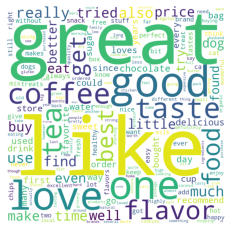

In [103]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
lst1 = sorted(HIGH.items(),key=lambda item:item[1], reverse=True)
Dict1 = dict(lst1)
highest_wordcloud = WordCloud(background_color="white",width=1000,height=1000).generate_from_frequencies(Dict1)
plt.imshow(highest_wordcloud)
plt.axis('off')
plt.show()

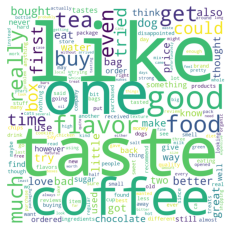

In [105]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
lst2 = sorted(LOW.items(),key=lambda item:item[1], reverse=True)
Dict2 = dict(lst2)
lowest_wordcloud = WordCloud(background_color="white",width=1000,height=1000).generate_from_frequencies(Dict2)
plt.imshow(lowest_wordcloud)
plt.axis('off')
plt.show()

From the distribution of high and low score WordCloud, we can find some patterns: when it comes to food rating, one of the most important aspects that buyers care about is food taste, which is reflected in the word ‘taste’，‘flavor’ are quite prominent in any WordCloud. For certain foods, it seems that customers are more concerned about the reputation of coffee, as the size of the word 'coffee' is large in both wordClouds. Besides, more healthy, lower-pricing and delicious food tends to be purchased by customers.

# Challenges

The first challenge is what we mentioned above: wiith regards to the Collaborative Filtering model, we couldn't have a way to build a large enough training Utility Matrix due to the overflow of int32 data and compatibility with different version of Pandas and Python, so inevitably, we ended up getting less accurate predictions than the previous two models. 

The second challenge is that the generation of our unpurchased data is based on data pairs of purchase behavior. Specifically, we extract users and food separately, and combine them into a set of data pairs which have never present before in our training data, and then we define them as "unpurchased". But this definition does not seem to be so precise, because the reason for not buying a good for a user is not only that he is not interested in this product, but also he may not encouter this goods on the website, even if he is satisfied with the item. Besides, it is likely for a customer to buy this stuff in other platform, indicating he may actually have buying potential.

The third is that we may have more hyperparameters to tune. In our project, we only fine tune the two parameters of our model, which seems not enough if we want to go deeper with sentiment analysis. Hence, we need to select more appropriate parameters and make our model more precise.

# Future Direction

1. We will try different parameters for our model. (more parameters + board data range)
2. Try to figure out how to build a bigger utility matrix in order to make our third model better.
3. Find a faster way to execute our code.
4. For time-varying data, we could use exponential or polynomial fitting to see whether there is a significant increase in sales number.